.. _basic_usage_tutorial:

.. currentmodule:: thunder

# Basic usage

Thunder offers a variety of analyses and workflows for spatial and temporal data. We'll walk through a very simple example here as an introduction. The entry point for most workflows is the ``ThunderContext``. If you type ``thunder`` to start the interactive shell, this context is automatically provided as ``tsc``, which is a thin wrapper for the ``SparkContext`` that provides functionality for loading data.

We'll start by loading some example data:

In [1]:
data = tsc.loadExample('fish-series')

``data`` is a distributed collection of key-value records, each containing a coordinate identifier and the time series of a single voxel. We can look at the first record by using ``first()``. It's a key-value pair, where the key is a tuple of int (representing a spatial coordinate within the imaging volume) and the value is an one-dimensional array:

In [2]:
key, value = data.first()

In [3]:
key

(0, 0, 0)

We see that the ``first`` key in the fish ``Series`` data is the tuple (0,0,0), corresponding to an x, y, z coordinate at an outer corner of the volume.

In [4]:
value.shape

(240,)

The value in this case is a time series of 240 observations, represented as a 1d numpy array.

We can extract a random subset of voxels and plot their time series, after applying a simple baseline normalization. Here and elsewhere, we'll use the excellent ``seaborn`` package for styling figures, but this is entirely optional.

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

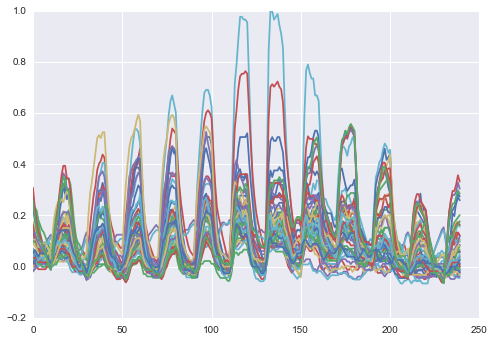

In [7]:
examples = data.toTimeSeries().normalize().subset(50, thresh=0.05)
sns.set_style('darkgrid')
plt.plot(examples.T);

We can also compute the mean value for each pixel using the ``seriesMean`` method:

In [8]:
means = data.seriesMean()
means.first()

((0, 0, 0), 25.824999999999999)

``means`` is now itself a ``Series``, where the value of each record is the mean across the time series for that voxel.

 For this ``Series``, since the keys correspond to spatial coordinates, we can ``pack`` the results back into a local array. ``pack`` is an operation that converts ``Series`` data, with spatial coordinates as keys, into an n-dimensional numpy array on the driver node of a Spark cluster. In this case, the result is 3d, with two planes:

In [9]:
img = means.pack()
img.shape

(76, 87, 2)

``pack`` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. For larger data sets, this can be very problematic - it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to ``pack`` large image data sets! (See the ``Series`` tutorial for more on how to do this.) In this case, after taking the ``mean`` the example data set is quite small, so ``pack``ing it is no problem.

To look at this array as an image, we'll use `matplotlib` via a helper function included with Thunder.

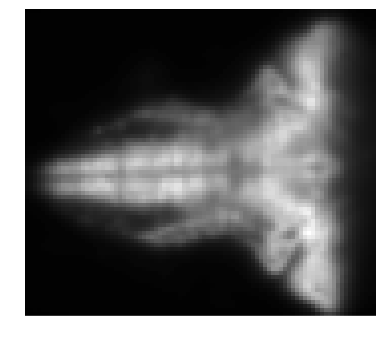

In [10]:
from thunder import Colorize
image = Colorize.image
image(img[:,:,0])

It's also easy to export the result to a ``numpy`` or ``MAT`` file.

In [11]:
tsc.export(img, "directory", "npy")
tsc.export(img, "directory", "mat")

This will put a ``npy`` file or ``MAT`` file called ``meanval`` in the folder ``directory`` in your current directory. 